# Model Training and Storing

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json

In [2]:
# Loading the MNIST dataset
mnist = tf.keras.datasets.mnist

# Load training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# x_train and x_test contain grayscale 28*28 images
# y_train and y_test contain the actual (ground truth) number (digit) that is in the picture

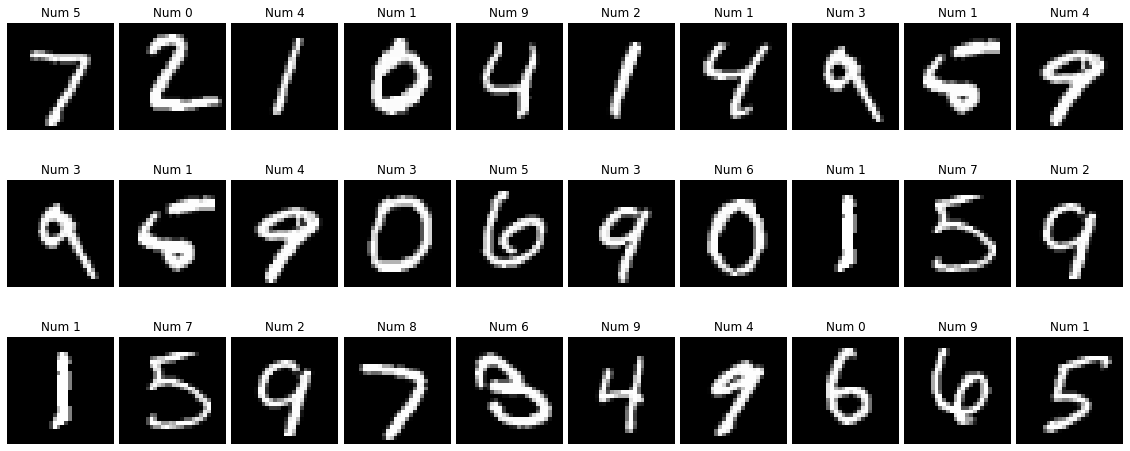

In [3]:
# Let's visualize some of these images
import matplotlib.pyplot as plt

start_index = 0

num_rows, num_cols = 3, 10
f, ax = plt.subplots(num_rows, num_cols, figsize=(20,8),
                     gridspec_kw={'wspace':0.05, 'hspace':0.3})

for r in range(num_rows):
    for c in range(num_cols):
        image_index = start_index + r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(x_test[image_index], cmap='gray')
        ax[r,c].set_title('Num %d' % y_train[image_index])
        
plt.subplots_adjust(hspace=2)  # make adjustments so that titles are shown correctly
plt.show()

In [4]:
# Let's write the datasets into JSON-lines files

# We will assign an 'id' column to each record (image), as well as a 'label'. The pixel array is represented under 'array'
train_json = {'id':[], 'array':[], 'label':[]}
test_json = {'id':[], 'array':[], 'label':[]}

cnt=0
for rec in x_train:
    train_json['id'].append(cnt)
    train_json['array'].append(rec.tolist())
    train_json['label'].append(y_train[cnt])
    cnt+=1

cnt=0
for rec in x_test:
    test_json['id'].append(cnt)
    test_json['array'].append(rec.tolist())
    test_json['label'].append(y_test[cnt])
    cnt+=1

train_records = pd.DataFrame(train_json)
test_records = pd.DataFrame(test_json)

train_records.to_json("./data/train.json", orient="records", lines=True)
test_records.to_json("./data/test.json", orient="records", lines=True)

In [5]:
# We are now ready to train a model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ]
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fit model using training data
model.fit(x_train, y_train, epochs=5)

2021-11-16 13:39:20.390847: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2178 - accuracy: 0.9351
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0972 - accuracy: 0.9707
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0703 - accuracy: 0.9778
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0538 - accuracy: 0.9828
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0416 - accuracy: 0.9863


In [6]:
# Store model weights, which we later load in model script
model.save_weights('./binaries/tf_mnist_cp.h5')

# Store model directly to a h5 file
model.save("./binaries/mnist.h5")

In [7]:
# To test that the saved model can be loaded and used for predictions, we proceed as follows:

# Either load the saved model directly from the .h5 file:
model_from_saved_model = tf.keras.models.load_model('./binaries/mnist.h5')
print("Sample prediction: ", model_from_saved_model.predict(x_test[:1]))

# Or load the weights from the .h5 file:
model_from_weighst = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ]
)

model_from_weighst.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_from_weighst.load_weights('./binaries/tf_mnist_cp.h5')
print("Sample Prediction: ", model_from_saved_model.predict(x_test[:1]))


Sample prediction:  [[5.1765541e-12 3.9118476e-11 2.9509131e-08 2.1680673e-07 2.7853999e-14
  1.8568846e-11 1.0495750e-15 9.9999976e-01 8.5356477e-10 1.4779316e-08]]
Sample Prediction:  [[5.1765541e-12 3.9118476e-11 2.9509131e-08 2.1680673e-07 2.7853999e-14
  1.8568846e-11 1.0495750e-15 9.9999976e-01 8.5356477e-10 1.4779316e-08]]


# Input/Output Schema

In [8]:
# input_schema.avsc

input_schema = {
    "name": "input_schema",
    "type": "record",
    "fields": [
        {
            "name": "id",
            "type": "int"
        },
        {
            "name": "array",
            "type": {
                "type": "array",
                "items": {
                    "type": "array",
                    "items": "float"
                }
            }
        },
        {
            "name": "label",
            "type": "int"
        }
    ]
}


output_schema = {
    "name": "output_schema",
    "type": "record",
    "fields": [
        {
            "name": "id",
            "type": "int"
        },
        {
            "name": "label",
            "type": "int"
        },
        {
            "name": "predicted_probs",
            "type": {
                "type": "array",
                "items": "float"
            }
        },
        {
            "name": "score",
            "type": "int"
        }
    ]
}

with open("input_schema.avsc", "w") as f:
    json.dump(input_schema, f)
f.close()

with open("output_schema.avsc", "w") as f:
    json.dump(output_schema, f)
f.close()

# Model Script

In [1]:
# modelop.schema.0: input_schema.avsc
# modelop.schema.1: output_schema.avsc

import tensorflow as tf
import numpy as np


# modelop.init
def begin():
    global model
    # Loading model from trained artifact    
    model = tf.keras.models.load_model('./binaries/mnist.h5')


# modelop.score
def action(datum):
    
    # Compute 10 probabilities, 1 for each possible digit
    predicted_probs = model.predict(np.array([datum["array"]])).tolist()[0]
    
    # Add these probabilities to the output
    datum["predicted_probs"] = predicted_probs

    # Add the best possible matching digit to the output
    datum["score"] = np.argmax(predicted_probs)

    # Remove input array from output
    del datum["array"]
    
    yield datum


In [2]:
# Let's test the model by running the begin() function to load the saved model first, then calling
# the action function on a sample input image
begin()

sample_score = next(
    action(
        {
            "id":0,
            "array":[
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0.0117647059,0.0705882353,0.0705882353,0.0705882353,0.4941176471,0.5333333333,0.6862745098,0.1019607843,0.6509803922,1.0,0.968627451,0.4980392157,0,0,0,0],
                [0,0,0,0,0,0,0,0,0.1176470588,0.1411764706,0.368627451,0.6039215686,0.6666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.8823529412,0.6745098039,0.9921568627,0.9490196078,0.7647058824,0.2509803922,0,0,0,0],
                [0,0,0,0,0,0,0,0.1921568627,0.9333333333,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9843137255,0.3647058824,0.3215686275,0.3215686275,0.2196078431,0.1529411765,0,0,0,0,0],
                [0,0,0,0,0,0,0,0.0705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.7137254902,0.968627451,0.9450980392,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0.3137254902,0.6117647059,0.4196078431,0.9921568627,0.9921568627,0.8039215686,0.0431372549,0,0.168627451,0.6039215686,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0.0549019608,0.0039215686,0.6039215686,0.9921568627,0.3529411765,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0.5450980392,0.9921568627,0.7450980392,0.0078431373,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0.0431372549,0.7450980392,0.9921568627,0.2745098039,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0.137254902,0.9450980392,0.8823529412,0.6274509804,0.4235294118,0.0039215686,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0.3176470588,0.9411764706,0.9921568627,0.9921568627,0.4666666667,0.0980392157,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1764705882,0.7294117647,0.9921568627,0.9921568627,0.5882352941,0.1058823529,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.062745098,0.3647058824,0.9882352941,0.9921568627,0.7333333333,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9764705882,0.9921568627,0.9764705882,0.2509803922,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.1803921569,0.5098039216,0.7176470588,0.9921568627,0.9921568627,0.8117647059,0.0078431373,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0.1529411765,0.5803921569,0.8980392157,0.9921568627,0.9921568627,0.9921568627,0.9803921569,0.7137254902,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0.0941176471,0.4470588235,0.8666666667,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7882352941,0.3058823529,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0.0901960784,0.2588235294,0.8352941176,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7764705882,0.3176470588,0.0078431373,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0.0705882353,0.6705882353,0.8588235294,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.7647058824,0.3137254902,0.0352941176,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0.2156862745,0.6745098039,0.8862745098,0.9921568627,0.9921568627,0.9921568627,0.9921568627,0.9568627451,0.5215686275,0.0431372549,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0.5333333333,0.9921568627,0.9921568627,0.9921568627,0.831372549,0.5294117647,0.5176470588,0.062745098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            ],
            "label":5
        }
    )
)

2022-02-25 13:42:24.965752: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Here's the output dictionary
sample_score

{'id': 0,
 'label': 5,
 'predicted_probs': [1.6703607593092091e-18,
  7.236827781996469e-13,
  1.6373989837614733e-12,
  0.00019582272216212004,
  1.2759772130497035e-22,
  0.9998041987419128,
  3.0448483937363467e-16,
  8.005316516016686e-14,
  1.5838779194991305e-14,
  4.432378075680532e-11],
 'score': 5}